# Part 14

## # Dataset

In [1]:
import pandas as pd
import numpy as np

In [135]:
df_train = pd.read_csv('../datasets/petr4_treinamento.csv')
df_train.shape, df_train.columns

((1245, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [136]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [137]:
def _isnull(df):
    for c in df.columns:
        cnt = df[pd.isnull(df[c])].shape[0]
        if cnt != 0:
            print(f'# {c}: {cnt} rows')

In [138]:
_isnull(df_train)

# Open: 3 rows
# High: 3 rows
# Low: 3 rows
# Close: 3 rows
# Adj Close: 3 rows
# Volume: 3 rows


In [139]:
df_train.dropna(axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(1242, 7)

In [140]:
df_train.shape

(1242, 7)

DAYS BEFORE = 90

In [141]:
def daysbefore(df, days_before, col):
    feature = []
    target = []
    for i in range(days_before, df.shape[0]):
        slice_start = i - days_before
        slice_stop = i
        feature.append(df[col].iloc[slice_start:slice_stop].values)
        target.append(df[col].iloc[i])
    return np.array(feature), np.array(target)

In [142]:
x, y = daysbefore(df_train, 90, 'Open')

In [143]:
df_open_train = pd.DataFrame(data=x)
df_open_train['target'] = y
df_open_train.shape

(1152, 91)

In [144]:
df_open_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1147,13.64,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,...,15.36,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75
1148,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,...,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75
1149,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,...,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99
1150,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,...,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10
1151,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,15.02,...,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10,16.10


In [145]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1152, 90, 1), (1152,))

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

f'{xtrain.shape}, {ytrain.shape}, {xtest.shape}, {ytest.shape}'

'(864, 90, 1), (864,), (288, 90, 1), (288,)'

## # Model

In [28]:
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dropout, Dense, LSTM, RNN

In [94]:
def model():
    clear_session()

    model = Sequential()

    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain.shape[1], 1)))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    
    model.add(LSTM(units=50))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    
    print(model.summary())
    
    return model

In [95]:
clf = model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [96]:
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 106ms/step - loss: 75.9023 - mae: 7.5189 - val_loss: 35.4016 - val_mae: 4.9142
Epoch 2/200
27/27 [==============================] - 2s 64ms/step - loss: 29.5326 - mae: 4.4939 - val_loss: 22.7206 - val_mae: 3.9342
Epoch 3/200
27/27 [==============================] - 2s 64ms/step - loss: 20.0321 - mae: 3.5365 - val_loss: 14.0386 - val_mae: 2.8519
Epoch 4/200
27/27 [==============================] - 2s 65ms/step - loss: 13.4697 - mae: 2.8499 - val_loss: 9.4745 - val_mae: 2.2963
Epoch 5/200
27/27 [==============================] - 2s 65ms/step - loss: 10.9730 - mae: 2.5353 - val_loss: 6.5255 - val_mae: 1.8433
Epoch 6/200
27/27 [==============================] - 2s 65ms/step - loss: 8.7049 - mae: 2.2613 - val_loss: 4.9683 - val_mae: 1.6286
Epoch 7/200
27/27 [==============================] - 2s 65ms/step - loss: 8.6859 - mae: 2.3218 - val_loss: 4.6174 - val_mae: 1.6802
Epoch 8/200
27/27 [==============================] - 2s 66ms/step -

27/27 [==============================] - 2s 64ms/step - loss: 4.7056 - mae: 1.6492 - val_loss: 0.5679 - val_mae: 0.5317
Epoch 63/200
27/27 [==============================] - 2s 64ms/step - loss: 5.0371 - mae: 1.6912 - val_loss: 0.7910 - val_mae: 0.6256
Epoch 64/200
27/27 [==============================] - 2s 63ms/step - loss: 4.6555 - mae: 1.6846 - val_loss: 0.9655 - val_mae: 0.7713
Epoch 65/200
27/27 [==============================] - 2s 62ms/step - loss: 5.2172 - mae: 1.7867 - val_loss: 0.7914 - val_mae: 0.6528
Epoch 66/200
27/27 [==============================] - 2s 63ms/step - loss: 4.9078 - mae: 1.7007 - val_loss: 1.0728 - val_mae: 0.7572
Epoch 67/200
27/27 [==============================] - 2s 64ms/step - loss: 4.6063 - mae: 1.6787 - val_loss: 0.9662 - val_mae: 0.7823
Epoch 68/200
27/27 [==============================] - 2s 65ms/step - loss: 4.6561 - mae: 1.6513 - val_loss: 0.6401 - val_mae: 0.5587
Epoch 69/200
27/27 [==============================] - 2s 63ms/step - loss: 4.5700 

27/27 [==============================] - 2s 64ms/step - loss: 3.9437 - mae: 1.5486 - val_loss: 0.4899 - val_mae: 0.4825
Epoch 124/200
27/27 [==============================] - 2s 65ms/step - loss: 4.0624 - mae: 1.5745 - val_loss: 0.6386 - val_mae: 0.6334
Epoch 125/200
27/27 [==============================] - 2s 65ms/step - loss: 3.9237 - mae: 1.5350 - val_loss: 0.6734 - val_mae: 0.6522
Epoch 126/200
27/27 [==============================] - 2s 63ms/step - loss: 3.7579 - mae: 1.4890 - val_loss: 0.5781 - val_mae: 0.5722
Epoch 127/200
27/27 [==============================] - 2s 64ms/step - loss: 4.0945 - mae: 1.5564 - val_loss: 1.2760 - val_mae: 0.9955
Epoch 128/200
27/27 [==============================] - 2s 67ms/step - loss: 4.0925 - mae: 1.5484 - val_loss: 0.5698 - val_mae: 0.5844
Epoch 129/200
27/27 [==============================] - 2s 66ms/step - loss: 4.6572 - mae: 1.5751 - val_loss: 0.4136 - val_mae: 0.4506
Epoch 130/200
27/27 [==============================] - 2s 67ms/step - loss: 

27/27 [==============================] - 2s 65ms/step - loss: 3.2846 - mae: 1.3941 - val_loss: 0.8217 - val_mae: 0.6918
Epoch 185/200
27/27 [==============================] - 2s 64ms/step - loss: 3.4575 - mae: 1.4132 - val_loss: 0.5248 - val_mae: 0.5254
Epoch 186/200
27/27 [==============================] - 2s 64ms/step - loss: 3.5126 - mae: 1.4432 - val_loss: 0.6506 - val_mae: 0.6378
Epoch 187/200
27/27 [==============================] - 2s 63ms/step - loss: 3.5003 - mae: 1.4288 - val_loss: 0.4067 - val_mae: 0.4272
Epoch 188/200
27/27 [==============================] - 2s 68ms/step - loss: 3.3693 - mae: 1.4212 - val_loss: 0.4307 - val_mae: 0.4600
Epoch 189/200
27/27 [==============================] - 2s 63ms/step - loss: 3.5529 - mae: 1.4794 - val_loss: 0.3597 - val_mae: 0.4091
Epoch 190/200
27/27 [==============================] - 2s 64ms/step - loss: 3.4268 - mae: 1.4148 - val_loss: 0.4907 - val_mae: 0.5157
Epoch 191/200
27/27 [==============================] - 2s 65ms/step - loss: 

## # Evaluation

In [220]:
pred = clf.predict(xtest)

In [221]:
ytest.shape, pred.shape

((288,), (288, 1))

In [209]:
ytest.mean() - pred.mean()

0.23415341501193687

In [210]:
ytest.std() - pred.std()

-0.02007471726045118

### ## Test data

In [196]:
df_test = pd.read_csv('../datasets/petr4_teste.csv')
df_test.shape, df_test.columns

((22, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [197]:
df_test.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600


In [198]:
df_complete = pd.concat(objs=[df_train, df_test], axis=0)
df_complete.reset_index(inplace=True, drop=True)
df_complete.shape

(1264, 7)

In [199]:
df_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1259,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
1260,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
1261,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
1262,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0
1263,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600.0


In [235]:
x, y = daysbefore(df_complete, 90, 'Open')

In [236]:
x.shape, y.shape

((1174, 90), (1174,))

In [237]:
df_open_test = pd.DataFrame(data=x)
df_open_test['target'] = y
df_open_test.shape

(1174, 91)

In [239]:
df_open_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1169,15.25,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,...,17.040001,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000
1170,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,...,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001
1171,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,...,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000
1172,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,...,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000
1173,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,15.61,...,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000,19.740000


In [240]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1174, 90, 1), (1174,))

In [241]:
pred = clf.predict(x)

In [242]:
pred.shape, y.shape

((1174, 1), (1174,))

In [243]:
y.mean() - pred.mean()

0.25753281960264296

In [244]:
y.std() - pred.std()

-0.018483486639921054

In [245]:
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


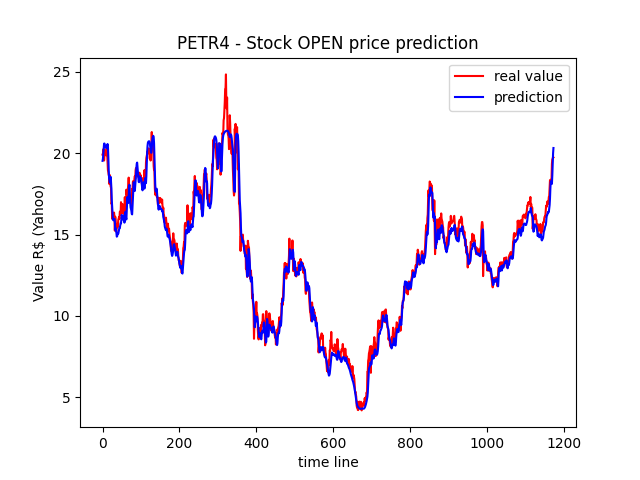

In [247]:
plt.plot(y, color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

## ## Multiple inputs

In [248]:
def daysbefore(df, days_before, col:None):
    feature = []
    target = []
    for i in range(days_before, df.shape[0]):
        slice_start = i - days_before
        slice_stop = i
        feature.append(df[col].iloc[slice_start:slice_stop].values)
        target.append(df[col].iloc[i])
    return np.array(feature), np.array(target)
